In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
import sys
from pathlib import Path
(Path.cwd().parent)

WindowsPath('C:/Users/jaesc2/GitHub/skforecast/dev')

## Librerias

In [3]:
## ForecasterAutoregMultiSeries
# ==============================================================================
import numpy as np
import pandas as pd

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import preprocess_levels

ImportError: cannot import name 'preprocess_levels' from 'skforecast.utils' (C:\Users\jaesc2\GitHub\skforecast\skforecast\utils\__init__.py)

## Pruebas

### Single serie

In [4]:
np.random.seed(123)
y = pd.Series(np.random.rand(10))
max_lag=3
lags=np.array([1,2,3])
exog = None

In [28]:
n_splits = len(y) - max_lag
X_data   = np.full(shape=(n_splits, max_lag), fill_value=np.nan, dtype=float)
y_data   = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype= float)

for i in range(n_splits):
    X_index = np.arange(i, max_lag + i)
    y_index = [max_lag + i]
    X_data[i, :] = y[X_index]
    y_data[i]    = y[y_index]

X_data = X_data[:, -lags] # Only keep needed lags
y_data = y_data.ravel()

print(y)
print(X_index)
print(X_data)
print(y_index)
print(y_data)

X_train = X_data
y_train = y_data

0    0.696469
1    0.286139
2    0.226851
3    0.551315
4    0.719469
5    0.423106
6    0.980764
7    0.684830
8    0.480932
9    0.392118
dtype: float64
[6 7 8]
[[0.22685145 0.28613933 0.69646919]
 [0.55131477 0.22685145 0.28613933]
 [0.71946897 0.55131477 0.22685145]
 [0.42310646 0.71946897 0.55131477]
 [0.9807642  0.42310646 0.71946897]
 [0.68482974 0.9807642  0.42310646]
 [0.4809319  0.68482974 0.9807642 ]]
[9]
[0.55131477 0.71946897 0.42310646 0.9807642  0.68482974 0.4809319
 0.39211752]


In [31]:
check_y(y=y)
y_values, y_index = preprocess_y(y=y)

if exog is not None:
    if len(exog) != len(y):
        raise Exception(
            "`exog` must have same number of samples as `y`."
        )
    check_exog(exog=exog)
    exog_values, exog_index = preprocess_exog(exog=exog)
    if not (exog_index[:len(y_index)] == y_index).all():
        raise Exception(
        ('Different index for `y` and `exog`. They must be equal '
        'to ensure the correct alignment of values.')      
        )

# X_train, y_train = self._create_lags(y=y_values)
X_train_col_names = [f"lag_{i}" for i in lags]
if exog is not None:
    col_names_exog = exog.columns if isinstance(exog, pd.DataFrame) else [exog.name]
    X_train_col_names.extend(col_names_exog)
    # The first `self.max_lag` positions have to be removed from exog
    # since they are not in X_train.
    X_train = np.column_stack((X_train, exog_values[max_lag:, ]))

X_train = pd.DataFrame(
            data    = X_train,
            columns = X_train_col_names,
            index   = y_index[max_lag: ]
          )

y_train = pd.Series(
            data  = y_train,
            index = y_index[max_lag: ],
            name  = 'y'
         )

print(y)
print("========")
print(X_train)
print("========")
print(y_train)

0    0.696469
1    0.286139
2    0.226851
3    0.551315
4    0.719469
5    0.423106
6    0.980764
7    0.684830
8    0.480932
9    0.392118
dtype: float64
      lag_1     lag_2     lag_3
3  0.226851  0.286139  0.696469
4  0.551315  0.226851  0.286139
5  0.719469  0.551315  0.226851
6  0.423106  0.719469  0.551315
7  0.980764  0.423106  0.719469
8  0.684830  0.980764  0.423106
9  0.480932  0.684830  0.980764
3    0.551315
4    0.719469
5    0.423106
6    0.980764
7    0.684830
8    0.480932
9    0.392118
Name: y, dtype: float64


### Multi-serie

In [46]:
y_1 = pd.Series(np.random.rand(10))
y_2 = pd.Series(np.random.rand(10))
exog_1 = pd.Series(np.random.rand(10))
exog_2 = pd.Series(np.random.rand(10))

df = pd.DataFrame({'serie_1': y_1, 'serie_2': y_2, 'exog_1': exog_1, 'exog_2': exog_2,
                   'date':pd.date_range(start='2022-01-01', periods=10, freq='5H')})

df = df.set_index('date')
df = df.asfreq('5H')
df = df.sort_index()

max_lag=3
lags=np.array([1,2,3])

series = df[['serie_1', 'serie_2']]
exog = df[['exog_1', 'exog_2']]

df

,serie_1,serie_2,exog_1,exog_2
date,,,,
2022-01-01 00:00:00,0.157957,0.823540,0.145651,0.998426
2022-01-01 05:00:00,0.284931,0.052616,0.983766,0.798464
2022-01-01 10:00:00,0.328161,0.364592,0.153216,0.477411
2022-01-01 15:00:00,0.070560,0.051346,0.215792,0.837244
2022-01-01 20:00:00,0.573243,0.235699,0.742374,0.711981
2022-01-02 01:00:00,0.589135,0.217804,0.957190,0.314574
2022-01-02 06:00:00,0.309275,0.676352,0.404353,0.698353
2022-01-02 11:00:00,0.386050,0.842057,0.089764,0.246427
2022-01-02 16:00:00,0.009236,0.532655,0.133031,0.000852


In [41]:
def _create_lags(y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

    n_splits = len(y) - max_lag
    X_data   = np.full(shape=(n_splits, max_lag), fill_value=np.nan, dtype=float)
    y_data   = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype= float)

    for i in range(n_splits):
        X_index = np.arange(i, max_lag + i)
        y_index = [max_lag + i]
        X_data[i, :] = y[X_index]
        y_data[i]    = y[y_index]

    X_data = X_data[:, -lags] # Only keep needed lags
    y_data = y_data.ravel()

    return X_data, y_data

In [81]:
from skforecast.utils import preprocess_levels

preprocess_levels(series)

{'1': 1, '2': 2}

In [85]:
y_1 = pd.Series(np.random.rand(10))
y_2 = pd.Series(np.random.rand(10))
exog_1 = pd.Series(np.random.rand(10))
exog_2 = pd.Series(np.random.rand(10))

df = pd.DataFrame({'s1': y_1, 's2': y_2, 'exog_1': exog_1, 'exog_2': exog_2,
                   'date':pd.date_range(start='2022-01-01', periods=10, freq='5H')})

df = df.set_index('date')
df = df.asfreq('5H')
df = df.sort_index()

max_lag=3
lags=np.array([1,2,3])

series = df[['s1', 's2']]
exog = df[['exog_1', 'exog_2']]

# ==============================================================================

if not isinstance(series, pd.DataFrame):
    raise Exception('`series` must be a pandas DataFrame.')

dict_levels = preprocess_levels(series)

for j, serie in enumerate(list(dict_levels.keys())):

    y = series[serie]
    check_y(y=y)
    y_values, y_index = preprocess_y(y=y)

    if j==0 and exog is not None:
        if len(exog) != len(series):
            raise Exception(
                "`exog` must have same number of samples as `series`."
            )
        check_exog(exog=exog)
        exog_values, exog_index = preprocess_exog(exog=exog)
        if not (exog_index[:len(y_index)] == y_index).all():
            raise Exception(
                ('Different index for `series` and `exog`. They must be equal '
                'to ensure the correct alignment of values.')      
            )

    X_train, y_train = _create_lags(y=y_values)
    X_train_col_names = [f"lag_{i}" for i in lags]

    X_level = np.full(shape=(len(X_train), 1), fill_value=f'{dict_levels[serie]}')
    X_train_col_names.append('level')
    X_train = np.column_stack((X_train, X_level))

    if exog is not None:
        col_names_exog = exog.columns if isinstance(exog, pd.DataFrame) else [exog.name]
        X_train_col_names.extend(col_names_exog)
        # The first `self.max_lag` positions have to be removed from exog
        # since they are not in X_train.
        X_train = np.column_stack((X_train, exog_values[max_lag:, ]))

    if j==0:
        X_train_df = pd.DataFrame(
                         data    = X_train,
                         columns = X_train_col_names
                     )

        y_train_df = pd.Series(
                        data  = y_train,
                        name  = 'y'
                     )
    else:
        X_train_df = pd.concat([X_train_df, 
                                pd.DataFrame(
                                    data    = X_train,
                                    columns = X_train_col_names
                                )
                               ]
                     )

        y_train_df = pd.concat([y_train_df, 
                                pd.Series(
                                    data  = y_train,
                                    name  = 'y'
                                )
                               ]
                     )

display(X_train_df)
display(y_train_df)
display(y_index)

,lag_1,lag_2,lag_3,level,exog_1,exog_2
0,0.4547229498874479,0.12827556270906715,0.6076205631455747,0,0.20953122627730225,0.47057215014408915
1,0.9064662357552927,0.4547229498874479,0.12827556270906715,0,0.9441407465045011,0.5059125374749236
2,0.7363699126847573,0.9064662357552927,0.4547229498874479,0,0.16285744642613575,0.7842974071318418
3,0.7733588250764596,0.7363699126847573,0.9064662357552927,0,0.30842992856374984,0.043440313257658514
4,0.5339511793465351,0.7733588250764596,0.7363699126847573,0,0.98365737812673,0.5676396537403264
5,0.26793779774979176,0.5339511793465351,0.7733588250764596,0,0.71072313083691,0.40454851699342387
6,0.1565410607133102,0.26793779774979176,0.5339511793465351,0,0.8817706273859857,0.3646856183619853
0,0.609568975699389,0.17509051028314637,0.2900796244961211,1,0.20953122627730225,0.47057215014408915
1,0.46470014291162043,0.609568975699389,0.17509051028314637,1,0.9441407465045011,0.5059125374749236
2,0.8933674757993382,0.46470014291162043,0.609568975699389,1,0.16285744642613575,0.7842974071318418


0    0.906466
1    0.736370
2    0.773359
3    0.533951
4    0.267938
5    0.156541
6    0.942138
0    0.464700
1    0.893367
2    0.313200
3    0.243505
4    0.863913
5    0.622847
6    0.061554
Name: y, dtype: float64

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 05:00:00',
               '2022-01-01 10:00:00', '2022-01-01 15:00:00',
               '2022-01-01 20:00:00', '2022-01-02 01:00:00',
               '2022-01-02 06:00:00', '2022-01-02 11:00:00',
               '2022-01-02 16:00:00', '2022-01-02 21:00:00'],
              dtype='datetime64[ns]', name='date', freq='5H')

In [49]:
X_level = np.full(shape=(1, max_lag), fill_value='serie_1')
X_level

array([['serie_1', 'serie_1', 'serie_1']], dtype='<U7')

In [56]:
X_train.shape

(7, 3)

In [57]:
X_level = np.full(shape=(len(X_train), 1), fill_value=f'{col}')
X_level.shape

(1, 7)

In [63]:
np.column_stack((np.array([1,2]), np.array([1,2]), np.array([1,2])))

array([[1, 1, 1],
       [2, 2, 2]])

## ForecasterAutoregMultiSeries_test

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [67]:
from typing import Union, Dict, List, Tuple, Any, Optional
import warnings
import logging
import numpy as np
import pandas as pd
import sklearn
import sklearn.pipeline
from sklearn.base import clone
from copy import copy

import skforecast
from skforecast.ForecasterBase import ForecasterBase
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import preprocess_levels

logging.basicConfig(
    format = '%(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)


class ForecasterAutoregMultiSeries_test(ForecasterBase):
    '''
    This class turns any regressor compatible with the scikit-learn API into a
    recursive autoregressive (multi-step) forecaster.
    
    Parameters
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API.
        
    lags : int, list, 1d numpy ndarray, range
        Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
            `int`: include lags from 1 to `lags` (included).
            `list`, `numpy ndarray` or `range`: include only lags present in `lags`,
            all elements must be int.

    
    Attributes
    ----------
    regressor : regressor or pipeline compatible with the scikit-learn API
        An instance of a regressor or pipeline compatible with the scikit-learn API.
        
    lags : numpy ndarray
        Lags used as predictors.
        
    max_lag : int
        Maximum value of lag included in `lags`.

    last_window : pandas Series
        Last window the forecaster has seen during trained. It stores the
        values needed to predict the next `step` right after the training data.
        
    window_size: int
        Size of the window needed to create the predictors. It is equal to
        `max_lag`.
        
    fitted: Bool
        Tag to identify if the regressor has been fitted (trained).
        
    index_type : type
        Type of index of the input used in training.
        
    index_freq : str
        Frequency of Index of the input used in training.
        
    training_range: pandas Index
        First and last values of index of the data used during training.
        
    included_exog : bool
        If the forecaster has been trained using exogenous variable/s.
        
    exog_type : type
        Type of exogenous variable/s used in training.
        
    exog_col_names : list
        Names of columns of `exog` if `exog` used in training was a pandas
        DataFrame.

    X_train_col_names : list
        Names of columns of the matrix created internally for training.
        
    in_sample_residuals: numpy ndarray
        Residuals of the model when predicting training data. Only stored up to
        1000 values.
        
    out_sample_residuals: numpy ndarray
        Residuals of the model when predicting non training data. Only stored
        up to 1000 values.

    creation_date: str
        Date of creation.

    fit_date: str
        Date of last fit.

    skforcast_version: str
        Version of skforecast library used to create the forecaster.
     
    '''
    
    def __init__(self, regressor, lags: Union[int, np.ndarray, list]) -> None:
        
        self.regressor            = regressor
        self.index_type           = None
        self.index_freq           = None
        self.index_values         = None
        self.training_range       = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.out_sample_residuals = None
        self.fitted               = False
        self.levels_dict          = None
        self.level                = None
        self.creation_date        = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.fit_date             = None
        self.skforcast_version    = skforecast.__version__
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('Minimum value of lags allowed is 1.')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('Minimum value of lags allowed is 1.')

        if isinstance(lags, (list, np.ndarray)):
            for lag in lags:
                if not isinstance(lag, (int, np.int64, np.int32)):
                    raise Exception('Values in lags must be int.')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                '`lags` argument must be int, 1d numpy ndarray, range or list. '
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        self.window_size = self.max_lag


    def __repr__(self) -> str:
        '''
        Information displayed when a ForecasterAutoreg object is printed.
        '''

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            name_pipe_steps = tuple(name + "__" for name in self.regressor.named_steps.keys())
            params = {key : value for key, value in self.regressor.get_params().items() \
                     if key.startswith(name_pipe_steps)}
        else:
            params = self.regressor.get_params()

        info = (
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"{str(type(self)).split('.')[1]} \n"
            f"{'=' * len(str(type(self)).split('.')[1])} \n"
            f"Regressor: {self.regressor} \n"
            f"Lags: {self.lags} \n"
            f"Window size: {self.window_size} \n"
            f"Included exogenous: {self.included_exog} \n"
            f"Type of exogenous variable: {self.exog_type} \n"
            f"Exogenous variables names: {self.exog_col_names} \n"
            f"Training range: {self.training_range.to_list() if self.fitted else None} \n"
            f"Training index type: {str(self.index_type).split('.')[-1][:-2] if self.fitted else None} \n"
            f"Training index frequency: {self.index_freq if self.fitted else None} \n"
            f"Regressor parameters: {params} \n"
            f"Creation date: {self.creation_date} \n"
            f"Last fit date: {self.fit_date} \n"
            f"Skforecast version: {self.skforcast_version} \n"
        )

        return info

    
    def _create_lags(self, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        '''       
        Transforms a 1d array into a 2d array (X) and a 1d array (y). Each row
        in X is associated with a value of y and it represents the lags that
        precede it.
        
        Notice that, the returned matrix X_data, contains the lag 1 in the first
        column, the lag 2 in the second column and so on.
        
        Parameters
        ----------        
        y : 1d numpy ndarray
            Training time series.

        Returns 
        -------
        X_data : 2d numpy ndarray, shape (samples - max(self.lags), len(self.lags))
            2d numpy array with the lagged values (predictors).
        
        y_data : 1d np.ndarray, shape (samples - max(self.lags),)
            Values of the time series related to each row of `X_data`.
            
        '''
          
        n_splits = len(y) - self.max_lag
        X_data   = np.full(shape=(n_splits, self.max_lag), fill_value=np.nan, dtype=float)
        y_data   = np.full(shape=(n_splits, 1), fill_value=np.nan, dtype= float)

        for i in range(n_splits):
            X_index = np.arange(i, self.max_lag + i)
            y_index = [self.max_lag + i]
            X_data[i, :] = y[X_index]
            y_data[i]    = y[y_index]
            
        X_data = X_data[:, -self.lags] # Only keep needed lags
        y_data = y_data.ravel()
            
        return X_data, y_data


    def create_train_X_y(
        self,
        series: pd.DataFrame,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> Tuple[pd.DataFrame, pd.Series]:
        '''
        Create training matrices from univariate time series and exogenous
        variables.
        
        Parameters
        ----------        
        series : pandas DataFrame
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned.

        Returns 
        -------
        X_train : pandas DataFrame, shape (len(y) - self.max_lag, len(self.lags))
            Pandas DataFrame with the training values (predictors).
            
        y_train : pandas Series, shape (len(y) - self.max_lag, )
            Values (target) of the time series related to each row of `X_train`.
        
        '''
        
        if not isinstance(series, pd.DataFrame):
            raise Exception('`series` must be a pandas DataFrame.')

        self.levels_dict = preprocess_levels(series)
        
        for j, serie in enumerate(list(self.levels_dict.keys())):

            y = series[serie]
            check_y(y=y)
            y_values, y_index = preprocess_y(y=y)

            if j==0 and exog is not None:
                if len(exog) != len(series):
                    raise Exception(
                        "`exog` must have same number of samples as `series`."
                    )
                check_exog(exog=exog)
                exog_values, exog_index = preprocess_exog(exog=exog)
                if not (exog_index[:len(y_index)] == y_index).all():
                    raise Exception(
                        ('Different index for `series` and `exog`. They must be equal '
                        'to ensure the correct alignment of values.')      
                    )

            X_train, y_train = self._create_lags(y=y_values)
            X_train_col_names = [f"lag_{i}" for i in lags]

            X_level = np.full(shape=(len(X_train), 1), fill_value=f'{self.levels_dict[serie]}')
            X_train_col_names.append('level')
            X_train = np.column_stack((X_train, X_level))

            if exog is not None:
                col_names_exog = exog.columns if isinstance(exog, pd.DataFrame) else [exog.name]
                X_train_col_names.extend(col_names_exog)
                # The first `self.max_lag` positions have to be removed from exog
                # since they are not in X_train.
                X_train = np.column_stack((X_train, exog_values[max_lag:, ]))

            if j==0:
                X_train_df = pd.DataFrame(
                                 data    = X_train,
                                 columns = X_train_col_names
                             )

                y_train_df = pd.Series(
                                data  = y_train,
                                name  = 'y'
                             )
            else:
                X_train_df = pd.concat([X_train_df, 
                                        pd.DataFrame(
                                            data    = X_train,
                                            columns = X_train_col_names
                                        )
                                       ]
                             )

                y_train_df = pd.concat([y_train_df, 
                                        pd.Series(
                                            data  = y_train,
                                            name  = 'y'
                                        )
                                       ]
                             )

        return X_train_df, y_train_df, y_index

        
    def fit(
        self,
        series: pd.DataFrame,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> None:
        '''
        Training Forecaster.
        
        Parameters
        ----------        
        series : pandas DataFrame
            Training time series.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned so
            that y[i] is regressed on exog[i].


        Returns 
        -------
        None
        
        '''
        
        # Reset values in case the forecaster has already been fitted.
        self.index_type           = None
        self.index_freq           = None
        self.index_values         = None
        self.last_window          = None
        self.included_exog        = False
        self.exog_type            = None
        self.exog_col_names       = None
        self.X_train_col_names    = None
        self.in_sample_residuals  = None
        self.fitted               = False
        self.levels_dict          = None
        self.level                = None
        self.training_range       = None
        
        if exog is not None:
            self.included_exog = True
            self.exog_type = type(exog)
            self.exog_col_names = \
                 exog.columns.to_list() if isinstance(exog, pd.DataFrame) else exog.name
 
        X_train, y_train, y_index = self.create_train_X_y(series=series, exog=exog)

        if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
            self.regressor.fit(X=X_train, y=y_train)
        else:
            self.regressor.fit(X=X_train.to_numpy(), y=y_train.to_numpy())
        
        self.fitted = True
        self.fit_date = pd.Timestamp.today().strftime('%Y-%m-%d %H:%M:%S')
        self.training_range = y_index[[0, -1]]
        self.index_type = type(y_index)
        if isinstance(y_index, pd.DatetimeIndex):
            self.index_freq = y_index.freqstr
        else: 
            self.index_freq = y_index.step
        self.index_values = y_index
        
        if not str(type(self.regressor)) == "<class 'xgboost.sklearn.XGBRegressor'>":
            residuals = y_train - self.regressor.predict(X_train)
        else:
            residuals = y_train - self.regressor.predict(X_train.to_numpy())

        residuals = pd.DataFrame(
                        {'in_sample_residuals': residuals,
                         'level'              : X_train.level
                        },
                        index = y_train.index
                    )

        if len(residuals) > 1000:
            # Only up to 1000 residuals are stored
            n_samples_per_level = int(1000/residuals['level'].nunique())
            
            residuals = residuals.groupby('level', group_keys=False) \
                        .apply(lambda x: x.sample(n_samples_per_level))
            
            if n_samples_per_level < 50:
                warnings.warn(
                    f'Due to the high number of levels, the size of residues stored in '
                    f'`in_sample_residuals` for each level is less than 50. '
                    f'Consider setting other residues using `set_out_sample_residuals` '
                    f'before using `predict_interval`.'
                )
            
        self.in_sample_residuals = residuals
        
        # The last time window of training data is stored so that lags needed as
        # predictors in the first iteration of `predict()` can be calculated.
        self.last_window = series.iloc[-self.max_lag:, ].copy()
    

    def _recursive_predict(
        self,
        steps: int,
        last_window: np.array,
        exog: np.array
    ) -> pd.Series:
        '''
        Predict n steps ahead. It is an iterative process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
        
        last_window : numpy ndarray
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
            
        exog : numpy ndarray, pandas DataFrame
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : numpy ndarray
            Predicted values.
            
        '''
        
        predictions = np.full(shape=steps, fill_value=np.nan)

        for i in range(steps):
            X = last_window[-self.lags].reshape(1, -1)
            if exog is not None:
                X = np.column_stack((X, exog[i, ].reshape(1, -1)))
            X = np.column_stack((X, np.array(self.levels_dict[self.level]).reshape(1, -1)))

            with warnings.catch_warnings():
                # Suppress scikitlearn warning: "X does not have valid feature names,
                # but NoOpTransformer was fitted with feature names".
                warnings.simplefilter("ignore")
                prediction = self.regressor.predict(X)
                predictions[i] = prediction.ravel()[0]

            # Update `last_window` values. The first position is discarded and 
            # the new prediction is added at the end.
            last_window = np.append(last_window[1:], prediction)

        return predictions

            
    def predict(
        self,
        steps: int,
        level: str,
        last_window: Optional[pd.DataFrame]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ) -> pd.Series:
        '''
        Predict n steps ahead. It is an recursive process in which, each prediction,
        is used as a predictor for the next step.
        
        Parameters
        ----------
        steps : int
            Number of future steps predicted.
            
        level : str
            Time series to be predicted.
            
        last_window : pandas DataFrame, default `None`
            Values of the series used to create the predictors (lags) need in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.

        Returns 
        -------
        predictions : pandas Series
            Predicted values.
            
        '''
        
        self.level = level
        
        check_predict_input(
            forecaster_type = type(self),
            steps           = steps,
            fitted          = self.fitted,
            included_exog   = self.included_exog,
            index_type      = self.index_type,
            index_freq      = self.index_freq,
            window_size     = self.window_size,
            last_window     = last_window,
            exog            = exog,
            exog_type       = self.exog_type,
            exog_col_names  = self.exog_col_names,
            max_steps       = None,
        ) 

        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog_values, _ = preprocess_exog(
                                    exog = exog[self.exog_col_names].iloc[:steps, ]
                                 )
            else: 
                exog_values, _ = preprocess_exog(
                                    exog = exog.iloc[:steps, ]
                                 )
        else:
            exog_values = None
            
        if last_window is not None:
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )  
        else:
            last_window = self.last_window[level]
            
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )
            
        predictions = self._recursive_predict(
                        steps       = steps,
                        last_window = copy(last_window_values),
                        exog        = copy(exog_values)
                      )

        predictions = pd.Series(
                        data  = predictions,
                        index = expand_index(
                                    index = last_window_index,
                                    steps = steps
                                ),
                        name = 'pred'
                      )

        return predictions
    
    
    def _estimate_boot_interval(
        self,
        steps: int,
        last_window: Optional[np.ndarray]=None,
        exog: Optional[np.ndarray]=None,
        interval: list=[5, 95],
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> np.ndarray:
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. This method only returns prediction intervals.
        See predict_intervals() to calculate both, predictions and intervals.
        
        Parameters
        ----------   
        steps : int
            Number of future steps predicted.
            
        last_window : 1d numpy ndarray shape (, max_lag), default `None`
            Values of the series used to create the predictors (lags) needed in the 
            first iteration of prediction (t + 1).
    
            If `last_window = `None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : numpy ndarray, default `None`
            Exogenous variable/s included as predictor/s.
            
        n_boot: int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.

        random_state: int
            Sets a seed to the random generator, so that boot intervals are always 
            deterministic.
            
        interval: list, default `[5, 95]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
        in_sample_residuals: bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user should have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).
            

        Returns 
        -------
        prediction_interval : numpy ndarray, shape (steps, 2)
            Interval estimated for each prediction by bootstrapping:
                first column = lower bound of the interval.
                second column= upper bound interval of the interval.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        '''
        
        if last_window is None:
            last_window = self.last_window[self.level]
            last_window = last_window.values

        boot_predictions = np.full(
                                shape      = (steps, n_boot),
                                fill_value = np.nan,
                                dtype      = float
                           )
        rng = np.random.default_rng(seed=random_state)
        seeds = rng.integers(low=0, high=10000, size=n_boot)

        for i in range(n_boot):
            # In each bootstraping iteration the initial last_window and exog 
            # need to be restored.
            last_window_boot = last_window.copy()
            if exog is not None:
                exog_boot = exog.copy()
            else:
                exog_boot = None
 
            if in_sample_residuals:
                residuals = self.in_sample_residuals[self.in_sample_residuals['level'] \
                                                     == str(self.levels_dict[self.level])] \
                                                    ['in_sample_residuals']
            else:
                residuals = self.out_sample_residuals

            rng = np.random.default_rng(seed=seeds[i])
            sample_residuals = rng.choice(
                                    a       = residuals,
                                    size    = steps,
                                    replace = True
                               )

            for step in range(steps):
                prediction = self._recursive_predict(
                                steps       = 1,
                                last_window = last_window_boot,
                                exog        = exog_boot 
                             )
                
                prediction_with_residual  = prediction + sample_residuals[step]
                boot_predictions[step, i] = prediction_with_residual

                last_window_boot = np.append(
                                       last_window_boot[1:],
                                       prediction_with_residual
                                   )
                
                if exog is not None:
                    exog_boot = exog_boot[1:]
                            
        prediction_interval = np.percentile(boot_predictions, q=interval, axis=1)
        prediction_interval = prediction_interval.transpose()
        
        return prediction_interval
    
        
    def predict_interval(
        self,
        steps: int,
        level: str,
        last_window: Optional[pd.DataFrame]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None,
        interval: list=[5, 95],
        n_boot: int=500,
        random_state: int=123,
        in_sample_residuals: bool=True
    ) -> pd.DataFrame:
        '''
        Iterative process in which, each prediction, is used as a predictor
        for the next step and bootstrapping is used to estimate prediction
        intervals. Both, predictions and intervals, are returned.
        
        Parameters
        ---------- 
        steps : int
            Number of future steps predicted.
        
        level : str
            Time series to be predicted.        
            
        last_window : pandas DataFrame, default `None`
            Values of the series used to create the predictors (lags) needed in the 
            first iteration of prediction (t + 1).
    
            If `last_window = None`, the values stored in` self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
            
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.
            
        interval: list, default `[5, 95]`
            Confidence of the prediction interval estimated. Sequence of percentiles
            to compute, which must be between 0 and 100 inclusive.
            
        n_boot: int, default `500`
            Number of bootstrapping iterations used to estimate prediction
            intervals.

        random_state: int, default 123
            Sets a seed to the random generator, so that boot intervals are always 
            deterministic.
            
        in_sample_residuals: bool, default `True`
            If `True`, residuals from the training data are used as proxy of
            prediction error to create prediction intervals. If `False`, out of
            sample residuals are used. In the latter case, the user should have
            calculated and stored the residuals within the forecaster (see
            `set_out_sample_residuals()`).

        Returns 
        -------
        predictions : pandas DataFrame
            Values predicted by the forecaster and their estimated interval:
                column pred = predictions.
                column lower_bound = lower bound of the interval.
                column upper_bound = upper bound interval of the interval.

        Notes
        -----
        More information about prediction intervals in forecasting:
        https://otexts.com/fpp2/prediction-intervals.html
        Forecasting: Principles and Practice (2nd ed) Rob J Hyndman and
        George Athanasopoulos.
            
        '''
        
        self.level = level
        
        check_predict_input(
            forecaster_type = type(self),
            steps           = steps,
            fitted          = self.fitted,
            included_exog   = self.included_exog,
            index_type      = self.index_type,
            index_freq      = self.index_freq,
            window_size     = self.window_size,
            last_window     = last_window,
            exog            = exog,
            exog_type       = self.exog_type,
            exog_col_names  = self.exog_col_names,
            max_steps       = None,
        ) 
        
        if exog is not None:
            if isinstance(exog, pd.DataFrame):
                exog_values, _ = preprocess_exog(
                                    exog = exog[self.exog_col_names].iloc[:steps, ]
                                 )
            else: 
                exog_values, _ = preprocess_exog(
                                    exog = exog.iloc[:steps, ]
                                 )
        else:
            exog_values = None
            
        if last_window is not None:
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )  
        else:
            last_window = self.last_window[level]
            
            last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = last_window
                                                    )
        
        # Since during predict() `last_window_values` and `exog_values` are modified,
        # the originals are stored to be used later.
        last_window_values_original = last_window_values.copy()
        if exog is not None:
            exog_values_original = exog_values.copy()
        else:
            exog_values_original = None
              
        predictions = self._recursive_predict(
                            steps       = steps,
                            last_window = last_window_values,
                            exog        = exog_values
                      )

        predictions_interval = self._estimate_boot_interval(
                                    steps       = steps,
                                    last_window = copy(last_window_values_original),
                                    exog        = copy(exog_values_original),
                                    interval    = interval,
                                    n_boot      = n_boot,
                                    random_state = random_state,
                                    in_sample_residuals = in_sample_residuals
                               )
        
        predictions = np.column_stack((predictions, predictions_interval))

        predictions = pd.DataFrame(
                        data = predictions,
                        index = expand_index(
                                    index = last_window_index,
                                    steps = steps
                                ),
                        columns = ['pred', 'lower_bound', 'upper_bound']
                      )

        return predictions

    
    def set_params(self, **params: dict) -> None:
        '''
        Set new values to the parameters of the scikit learn model stored in the
        ForecasterAutoreg.
        
        Parameters
        ----------
        params : dict
            Parameters values.

        Returns 
        -------
        self
        
        '''
        self.regressor = clone(self.regressor)
        self.regressor.set_params(**params)
        
        
    def set_lags(self, lags: Union[int, list, np.ndarray, range]) -> None:
        '''      
        Set new value to the attribute `lags`.
        Attributes `max_lag` and `window_size` are also updated.
        
        Parameters
        ----------
        lags : int, list, 1D np.array, range
            Lags used as predictors. Index starts at 1, so lag 1 is equal to t-1.
                `int`: include lags from 1 to `lags`.
                `list` or `np.array`: include only lags present in `lags`.

        Returns 
        -------
        None
        
        '''
        
        if isinstance(lags, int) and lags < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, (list, range, np.ndarray)) and min(lags) < 1:
            raise Exception('min value of lags allowed is 1')
            
        if isinstance(lags, int):
            self.lags = np.arange(lags) + 1
        elif isinstance(lags, (list, range)):
            self.lags = np.array(lags)
        elif isinstance(lags, np.ndarray):
            self.lags = lags
        else:
            raise Exception(
                f"`lags` argument must be `int`, `1D np.ndarray`, `range` or `list`. "
                f"Got {type(lags)}"
            )
            
        self.max_lag  = max(self.lags)
        self.window_size = max(self.lags)
        
        
    def set_out_sample_residuals(
        self, 
        residuals: pd.Series, 
        append: bool=True
    )-> None:
        '''
        Set new values to the attribute `out_sample_residuals`. Out of sample
        residuals are meant to be calculated using observations that did not
        participate in the training process.
        
        Parameters
        ----------
        residuals : pd.Series
            Values of residuals. If len(residuals) > 1000, only a random sample
            of 1000 values are stored.
            
        append : bool, default `True`
            If `True`, new residuals are added to the once already stored in the
            attribute `out_sample_residuals`. Once the limit of 1000 values is
            reached, no more values are appended. If False, `out_sample_residuals`
            is overwritten with the new residuals.
            
        Returns 
        -------
        self
        '''

        if not isinstance(residuals, pd.Series):
            raise Exception(
                f"`residuals` argument must be `pd.Series`. Got {type(residuals)}"
            )

        if len(residuals) > 1000:
            rng = np.random.default_rng(seed=123)
            residuals = rng.choice(a=residuals, size=1000, replace=False)
            residuals = pd.Series(residuals)   
      
        if append and self.out_sample_residuals is not None:
            free_space = max(0, 1000 - len(self.out_sample_residuals))
            if len(residuals) < free_space:
                residuals = np.hstack((
                                self.out_sample_residuals,
                                residuals
                            ))
            else:
                residuals = np.hstack((
                                self.out_sample_residuals,
                                residuals[:free_space]
                            ))

        self.out_sample_residuals = pd.Series(residuals)

    
    def get_feature_importance(self) -> pd.DataFrame:
        '''      
        Return feature importance of the regressor stored in the
        forecaster. Only valid when regressor stores internally the feature
        importance in the attribute `feature_importances_` or `coef_`.

        Parameters
        ----------
        self

        Returns
        -------
        feature_importance : pandas DataFrame
            Feature importance associated with each predictor.
        '''

        if isinstance(self.regressor, sklearn.pipeline.Pipeline):
            estimator = self.regressor[-1]
        else:
            estimator = self.regressor

        try:
            feature_importance = pd.DataFrame({
                                    'feature': self.X_train_col_names,
                                    'importance' : estimator.feature_importances_
                                })
        except:   
            try:
                feature_importance = pd.DataFrame({
                                        'feature': self.X_train_col_names,
                                        'importance' : estimator.coef_
                                    })
            except:
                warnings.warn(
                    f"Impossible to access feature importance for regressor of type {type(estimator)}. "
                    f"This method is only valid when the regressor stores internally "
                    f"the feature importance in the attribute `feature_importances_` "
                    f"or `coef_`."
                )

                feature_importance = None

        return feature_importance

In [68]:
forecaster.index_values

RangeIndex(start=0, stop=1723, step=1)

### Create forecaster

In [112]:
y_1 = pd.Series(np.random.rand(1723))
y_2 = pd.Series(np.random.rand(1723))
exog_1 = pd.Series(np.random.rand(1723))
exog_2 = pd.Series(np.random.rand(1723))

df = pd.DataFrame({'1': y_1, '2': y_2, 'exog_1': exog_1, 'exog_2': exog_2,
                   'date':pd.date_range(start='2022-01-01', periods=1723, freq='5H')})

df = df.set_index('date')
df = df.asfreq('5H')
df = df.sort_index()

max_lag=3
lags=np.array([1,2,3])

df = df.reset_index(drop=True)
print(df.shape)
df.head(3)

(1723, 4)


,1,2,exog_1,exog_2
0,0.810903,0.862447,0.261002,0.357133
1,0.112012,0.853779,0.289119,0.957170
2,0.927313,0.642518,0.457261,0.625761


In [113]:
# Create and fit forecaster
# ==============================================================================
from sklearn.linear_model import LinearRegression

forecaster = ForecasterAutoregMultiSeries_test(
                    regressor = LinearRegression(),
                    lags      = 3
             )

forecaster.fit(
    series = df[['1', '2']],)
#     exog   = df[['exog_1', 'exog_2']]
# )

forecaster

ForecasterAutoregMultiSeries_test'> 
Regressor: LinearRegression() 
Lags: [1 2 3] 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 1722] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-05-27 17:43:23 
Last fit date: 2022-05-27 17:43:23 
Skforecast version: 0.5.dev1 

In [118]:
forecaster.create_train_X_y(series = df[['1', '2']])[0]

,lag_1,lag_2,lag_3,level
0,0.9273127193993941,0.11201181984848962,0.8109032291716992,1
1,0.3575926410986252,0.9273127193993941,0.11201181984848962,1
2,0.3276142049719847,0.3575926410986252,0.9273127193993941,1
3,0.1970752857438085,0.3276142049719847,0.3575926410986252,1
4,0.6902688551676195,0.1970752857438085,0.3276142049719847,1
...,...,...,...,...
1715,0.6810683244673919,0.5564049893123771,0.7410450676108733,2
1716,0.16490624240818785,0.6810683244673919,0.5564049893123771,2
1717,0.9113565360352945,0.16490624240818785,0.6810683244673919,2
1718,0.21008368488340845,0.9113565360352945,0.16490624240818785,2


In [114]:
# Predict
# ==============================================================================
steps = 3
exog_1_test = pd.Series(np.random.rand(steps))
exog_2_test = pd.Series(np.random.rand(steps))

df_test = pd.DataFrame({'exog_1': exog_1_test, 'exog_2': exog_2_test})

predictions = forecaster.predict(
                steps = steps,
                level = '1',)
#                 exog = df_test[['exog_1', 'exog_2']]
#               )

print(forecaster.level)
predictions

1


1723    0.492350
1724    0.502121
1725    0.500182
Name: pred, dtype: float64

In [65]:
forecaster.in_sample_residuals[forecaster.in_sample_residuals['level'] == str(forecaster.levels_dict[forecaster.level])]['in_sample_residuals']

1523    0.105018
50     -0.128144
1267    0.120916
391     0.006695
992    -0.130922
Name: in_sample_residuals, dtype: float64

In [66]:
forecaster.in_sample_residuals[forecaster.in_sample_residuals['level'] \
                                                     == str(forecaster.levels_dict[forecaster.level])] \
                                                    ['in_sample_residuals']

1523    0.105018
50     -0.128144
1267    0.120916
391     0.006695
992    -0.130922
Name: in_sample_residuals, dtype: float64

#### Pruebas

In [126]:
X = forecaster.create_train_X_y(df[['s1', 's2']])[0]
X.level

0      0
1      0
2      0
3      0
4      0
      ..
992    1
993    1
994    1
995    1
996    1
Name: level, Length: 1994, dtype: object

In [59]:
forecaster.index_values

RangeIndex(start=0, stop=499, step=1)

In [60]:
forecaster.levels_dict

{'s1': 0, 's2': 1}

In [45]:
forecaster.last_window.values

array([[0.18412531, 0.4392954 ],
       [0.83900729, 0.13639005],
       [0.51206053, 0.4508429 ]])

In [62]:
forecaster.last_window['s1']

496    0.719042
497    0.114874
498    0.981913
Name: s1, dtype: float64

In [63]:
preprocess_last_window(forecaster.last_window)[0]

array([[0.71904162, 0.96936802],
       [0.11487381, 0.38861858],
       [0.9819126 , 0.05289527]])

In [64]:
forecaster.in_sample_residuals

0      0.099225
1      0.173431
2      0.122369
3     -0.114103
4     -0.021988
         ...   
491    0.187784
492   -0.164879
493    0.160717
494   -0.012769
495   -0.174215
Name: y, Length: 992, dtype: float64

In [66]:
pd.Series(
                    data  = forecaster.in_sample_residuals,
                    index = forecaster.in_sample_residuals.index,
                    name  = 'in_sample_residuals'
                 )

0      0.099225
1      0.173431
2      0.122369
3     -0.114103
4     -0.021988
         ...   
491    0.187784
492   -0.164879
493    0.160717
494   -0.012769
495   -0.174215
Name: in_sample_residuals, Length: 992, dtype: float64

In [43]:
pd.Series(forecaster.in_sample_residuals)

0      0.078133
1     -0.233654
2      0.020363
3      0.130580
4      0.028963
         ...   
995   -0.179021
996   -0.133909
997   -0.095682
998   -0.150806
999    0.140685
Length: 1000, dtype: float64

In [11]:
type(forecaster.in_sample_residuals)

pandas.core.series.Series

In [18]:
residuals = pd.Series(np.array([1,2,3,4,5,6]))
residuals

0    1
1    2
2    3
3    4
4    5
5    6
dtype: int64

In [19]:
rng = np.random.default_rng(seed=123)
residuals = rng.choice(a=residuals, size=10, replace=True)
residuals

array([1, 5, 4, 1, 6, 2, 2, 2, 3, 2])

In [70]:
pd.DataFrame({'y_1': y_1, 'y_2': y_2})

,y_1,y_2
0,0.673323,0.509373
1,0.030798,0.419975
2,0.625376,0.415746
3,0.157791,0.328772
4,0.996914,0.013004
...,...,...
1718,0.606940,0.992992
1719,0.534260,0.944517
1720,0.657966,0.887641
1721,0.477168,0.907346


In [75]:
df = pd.DataFrame({'1': pd.Series(np.arange(3)), 
                       '2': pd.Series(np.arange(3))
                      })

results = preprocess_levels(df)
expected = {'1': 1, '2': 2}

assert results == expected

In [76]:
results

{'1': 1, '2': 2}

In [111]:
from sklearn.linear_model import LinearRegression

forecaster = ForecasterAutoregMultiSeries_test(LinearRegression(), lags=3)
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                       '2': pd.Series(np.arange(7))
                      })

results = forecaster.create_train_X_y(series=series)
expected = (pd.DataFrame(
                data = np.array([['2.0', '1.0', '0.0', '1'],
                                 ['3.0', '2.0', '1.0', '1'],
                                 ['4.0', '3.0', '2.0', '1'],
                                 ['5.0', '4.0', '3.0', '1'],
                                 ['2.0', '1.0', '0.0', '2'],
                                 ['3.0', '2.0', '1.0', '2'],
                                 ['4.0', '3.0', '2.0', '2'],
                                 ['5.0', '4.0', '3.0', '2']]),
                index   = np.array([0, 1, 2, 3, 0, 1, 2, 3]),
                columns = ['lag_1', 'lag_2', 'lag_3', 'level']
            ),
            pd.Series(
                np.array([3, 4, 5, 6, 3, 4, 5, 6]),
                index = np.array([0, 1, 2, 3, 0, 1, 2, 3]))
           )

pd.testing.assert_frame_equal(results[0], expected[0])
assert (results[1] == expected[1]).all()

In [110]:
results[0].values

array([['2.0', '1.0', '0.0', '1'],
       ['3.0', '2.0', '1.0', '1'],
       ['4.0', '3.0', '2.0', '1'],
       ['5.0', '4.0', '3.0', '1'],
       ['2.0', '1.0', '0.0', '2'],
       ['3.0', '2.0', '1.0', '2'],
       ['4.0', '3.0', '2.0', '2'],
       ['5.0', '4.0', '3.0', '2']], dtype=object)

In [107]:
results[0].dtypes

lag_1    object
lag_2    object
lag_3    object
level    object
dtype: object

## ForecasterAutoregMultiSeries

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
## ForecasterAutoregMultiSeries
# ==============================================================================
import numpy as np
import pandas as pd

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg

from skforecast.model_selection.model_multi import _backtesting_forecaster_multiseries_refit
from skforecast.model_selection.model_multi import _backtesting_forecaster_multiseries_no_refit

from sklearn.linear_model import LinearRegression

In [3]:
y_1 = pd.Series(np.random.rand(20))
y_2 = pd.Series(np.random.rand(20))
exog_1 = pd.Series(np.random.rand(20))
exog_2 = pd.Series(np.random.rand(20))

df = pd.DataFrame({'s1': y_1, 's2': y_2, 'exog_1': exog_1, 'exog_2': exog_2,
                   'date':pd.date_range(start='2022-01-01', periods=20, freq='1D')})

df = df.set_index('date')
df = df.asfreq('1D')
df = df.sort_index()

max_lag=3
lags=np.array([1,2,3])

print(df.shape)
df.tail(3)

(20, 4)


,s1,s2,exog_1,exog_2
date,,,,
2022-01-18,0.573340,0.480967,0.781336,0.113705
2022-01-19,0.903297,0.397092,0.294954,0.399249
2022-01-20,0.570321,0.794527,0.298892,0.675801


In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = LinearRegression(),
                    lags      = 3
             )

forecaster.fit(
    series = df[['s1', 's2']],
    exog   = df[['exog_1', 'exog_2']]
)

forecaster

ForecasterAutoregMultiSeries 
Regressor: LinearRegression() 
Lags: [1 2 3] 
Window size: 3 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2022-01-20 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-06-03 12:45:39 
Last fit date: 2022-06-03 12:45:39 
Skforecast version: 0.5.dev1 

In [5]:
# Predict
# ==============================================================================
steps = 3
exog_1_test = pd.Series(np.random.rand(steps))
exog_2_test = pd.Series(np.random.rand(steps))

df_test = pd.DataFrame({'exog_1': exog_1_test, 'exog_2': exog_2_test,
                        'date':pd.date_range(start=df.index[-1], periods=steps, freq='1D')})

df_test = df_test.set_index('date')
df_test = df_test.asfreq('1D')
df_test = df_test.sort_index()

predictions = forecaster.predict(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']]
              )

print(forecaster.level)
predictions

s2


2022-01-21    0.306085
2022-01-22    0.286604
2022-01-23    0.448446
Freq: D, Name: pred, dtype: float64

In [6]:
forecaster.last_window

,s1,s2
date,,
2022-01-18,0.573340,0.480967
2022-01-19,0.903297,0.397092
2022-01-20,0.570321,0.794527


In [7]:
# Predict last window
# ==============================================================================
last_window = df[['s2']].tail(3)
display(last_window)

predictions = forecaster.predict(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']],
                last_window = last_window
              )

print(forecaster.level)
predictions

,s2
date,
2022-01-18,0.480967
2022-01-19,0.397092
2022-01-20,0.794527


s2


2022-01-21    0.306085
2022-01-22    0.286604
2022-01-23    0.448446
Freq: D, Name: pred, dtype: float64

In [8]:
# Predict interval
# ==============================================================================
predictions = forecaster.predict_interval(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']]
              )

print(forecaster.level)
predictions

s2


,pred,lower_bound,upper_bound
2022-01-21,0.306085,-0.061969,0.689429
2022-01-22,0.286604,-0.064741,0.700437
2022-01-23,0.448446,0.105916,0.859389


In [9]:
# Predict interval last_window
# ==============================================================================
predictions = forecaster.predict_interval(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']],
                last_window = last_window
              )

print(forecaster.level)
predictions

s2


,pred,lower_bound,upper_bound
2022-01-21,0.306085,-0.061969,0.689429
2022-01-22,0.286604,-0.064741,0.700437
2022-01-23,0.448446,0.105916,0.859389


In [10]:
# Predict interval out_sample_residuals
# ==============================================================================
simulated_residuals = pd.Series(np.random.normal(size=500))
forecaster.set_out_sample_residuals(residuals=simulated_residuals)

predictions = forecaster.predict_interval(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']],
                in_sample_residuals = False
              )

print(forecaster.level)
predictions

s2


,pred,lower_bound,upper_bound
2022-01-21,0.306085,-1.231725,2.080019
2022-01-22,0.286604,-1.242571,2.058231
2022-01-23,0.448446,-1.206050,2.288371


In [11]:
# Backtest forecaster refit
# ==============================================================================
metric, predictions_backtest = _backtesting_forecaster_multiseries_refit(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    initial_train_size = 12,
                                    fixed_train_size   = False,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-16 00:00:00  (n=16)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.07825676947244285,
                 pred
 2022-01-13  0.465677
 2022-01-14  0.637151
 2022-01-15  0.610023
 2022-01-16  0.563898
 2022-01-17  0.687500
 2022-01-18  0.578125
 2022-01-19  0.343750
 2022-01-20  0.625000)

In [12]:
# Backtest forecaster refit, fixed_train_size
# ==============================================================================
metric, predictions_backtest = _backtesting_forecaster_multiseries_refit(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    initial_train_size = 12,
                                    fixed_train_size   = True,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-05 00:00:00 -- 2022-01-16 00:00:00  (n=12)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.08573772234273207,
                 pred
 2022-01-13  0.465677
 2022-01-14  0.637151
 2022-01-15  0.610023
 2022-01-16  0.563898
 2022-01-17  0.778709
 2022-01-18  0.553976
 2022-01-19  0.362163
 2022-01-20  0.730563)

In [28]:
# Backtest forecaster no refit
# ==============================================================================
metric, predictions_backtest = _backtesting_forecaster_multiseries_no_refit(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    initial_train_size = 12,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.06214454426341384,
                 pred
 2022-01-13  0.465677
 2022-01-14  0.637151
 2022-01-15  0.610023
 2022-01-16  0.563898
 2022-01-17  0.729437
 2022-01-18  0.615910
 2022-01-19  0.506014
 2022-01-20  0.628508)

### Pruebas

In [12]:
forecaster.last_window

,s1,s2
597,0.773378,0.772900
598,0.979510,0.676482
599,0.871304,0.745478


In [31]:
level='s1'

last_window_values, last_window_index = preprocess_last_window(
                                                        last_window = forecaster.last_window[level]
                                                    )

X = last_window_values[-forecaster.lags].reshape(1, -1)
print(X)
levels_dummies = np.zeros(shape=(1, len(forecaster.in_sample_residuals.keys())), dtype= float)
print(levels_dummies)
print(list(forecaster.in_sample_residuals.keys()).index(level))
levels_dummies[0][list(forecaster.in_sample_residuals.keys()).index(level)] = 1.
print(levels_dummies)

X = np.column_stack((X, levels_dummies.reshape(1, -1)))
X

[[0.87130395 0.9795105  0.77337797]]
[[0. 0.]]
0
[[1. 0.]]


array([[0.87130395, 0.9795105 , 0.77337797, 1.        , 0.        ]])

In [23]:
a = np.array()

TypeError: array() missing required argument 'object' (pos 0)

In [24]:
np.append(a, np.array([2,3]) )

array([2., 3.])

In [7]:
pd.get_dummies(pd.Series(np.array(['a','b','c']))).values

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [14]:
c = np.array(([], []))
a = np.array(([1, 2, 3], [4,5,6]))
b = np.array(([1, 2, 3], [4,5,6]))
np.vstack((c,a))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 3

In [17]:
a = np.array(([1,2,3,4,5], [5,6,7,8,9]))
a

array([[1, 2, 3, 4, 5],
       [5, 6, 7, 8, 9]])

In [21]:
print(a[np.all(a < 3, axis = 1), 0])

[]


In [22]:
arr = np.asarray([[1, 'one'], [2, 'two'], [3, 'three'],
                  [4, 'four'], [5, 'five']])
 
arr

array([['1', 'one'],
       ['2', 'two'],
       ['3', 'three'],
       ['4', 'four'],
       ['5', 'five']], dtype='<U11')

In [23]:
fltr = np.asarray(['two', 'four'])
arr[np.in1d(arr[:, 1], fltr)]

array([['2', 'two'],
       ['4', 'four']], dtype='<U11')

In [24]:
a = np.array(([1,2,3,4,5], [5,6,7,8,9]))
a

array([[1, 2, 3, 4, 5],
       [5, 6, 7, 8, 9]])

In [26]:
a[np.in1d(arr[:, 1], np.array([2]))]

C:\Users\jaesc2\Miniconda3\envs\food_digital\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 5

In [29]:
a[a[:, 0] == 1]

array([[1, 2, 3, 4, 5]])

In [7]:
a = {'a': [1,2,3,4], 'b': [3,4,5]}

In [18]:
len(list(a.values())[0])*len(list(a.keys()))

8

In [17]:
for value in a.values():
    print(len(value))

4
3


In [19]:
rng = np.random.default_rng(seed=123)
residuals = rng.choice(a=a['a'], size=2, replace=False)  
residuals

array([1, 3])

In [7]:
rng = np.random.default_rng(seed=123)
residuals = rng.choice(a=pd.Series(np.array([1,2,3,4,5])), size=2, replace=False)  
residuals

array([1, 4])

## Tests

In [68]:
import pytest
from pytest import approx

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [35]:
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                       '2': pd.Series(np.arange(7))
                      })

results = forecaster.create_train_X_y(series=series)
expected = (pd.DataFrame(
                data = np.array([[2.0, 1.0, 0.0, 1., 0.],
                                 [3.0, 2.0, 1.0, 1., 0.],
                                 [4.0, 3.0, 2.0, 1., 0.],
                                 [5.0, 4.0, 3.0, 1., 0.],
                                 [2.0, 1.0, 0.0, 0., 1.],
                                 [3.0, 2.0, 1.0, 0., 1.],
                                 [4.0, 3.0, 2.0, 0., 1.],
                                 [5.0, 4.0, 3.0, 0., 1.]]),
                index   = np.array([0, 1, 2, 3, 4, 5, 6, 7]),
                columns = ['lag_1', 'lag_2', 'lag_3', '1', '2']
            ),
            pd.Series(
                np.array([3, 4, 5, 6, 3, 4, 5, 6]),
                index = np.array([0, 1, 2, 3, 0, 1, 2, 3]))
        )

pd.testing.assert_frame_equal(results[0], expected[0])
assert (results[1] == expected[1]).all()

In [36]:
results[0]

,lag_1,lag_2,lag_3,1,2
0,2.0,1.0,0.0,1.0,0.0
1,3.0,2.0,1.0,1.0,0.0
2,4.0,3.0,2.0,1.0,0.0
3,5.0,4.0,3.0,1.0,0.0
4,2.0,1.0,0.0,0.0,1.0
5,3.0,2.0,1.0,0.0,1.0
6,4.0,3.0,2.0,0.0,1.0
7,5.0,4.0,3.0,0.0,1.0


In [38]:
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                       '2': pd.Series(np.arange(7))
                      })

results = forecaster.create_train_X_y(
                        series = series,
                        exog   = pd.Series(np.arange(100, 107), name='exog')            
          )

expected = (pd.DataFrame(
                data = np.array([[2.0, 1.0, 0.0, 103., 1., 0.],
                                 [3.0, 2.0, 1.0, 104., 1., 0.],
                                 [4.0, 3.0, 2.0, 105., 1., 0.],
                                 [5.0, 4.0, 3.0, 106., 1., 0.],
                                 [2.0, 1.0, 0.0, 103., 0., 1.],
                                 [3.0, 2.0, 1.0, 104., 0., 1.],
                                 [4.0, 3.0, 2.0, 105., 0., 1.],
                                 [5.0, 4.0, 3.0, 106., 0., 1.]]),
                index   = np.array([0, 1, 2, 3, 4, 5, 6, 7]),
                columns = ['lag_1', 'lag_2', 'lag_3', 'exog', '1', '2']
            ),
            pd.Series(
                np.array([3, 4, 5, 6, 3, 4, 5, 6]),
                index = np.array([0, 1, 2, 3, 0, 1, 2, 3]))
        )

pd.testing.assert_frame_equal(results[0], expected[0])
assert (results[1] == expected[1]).all()

In [39]:
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                       '2': pd.Series(np.arange(7))
                      })

results = forecaster.create_train_X_y(
                        series = series,
                        exog = pd.DataFrame({
                                'exog_1' : np.arange(100, 107),
                                'exog_2' : np.arange(1000, 1007)
                               })           
          )

expected = (pd.DataFrame(
                data = np.array([[2.0, 1.0, 0.0, 103., 1003., 1., 0.],
                                 [3.0, 2.0, 1.0, 104., 1004., 1., 0.],
                                 [4.0, 3.0, 2.0, 105., 1005., 1., 0.],
                                 [5.0, 4.0, 3.0, 106., 1006., 1., 0.],
                                 [2.0, 1.0, 0.0, 103., 1003., 0., 1.],
                                 [3.0, 2.0, 1.0, 104., 1004., 0., 1.],
                                 [4.0, 3.0, 2.0, 105., 1005., 0., 1.],
                                 [5.0, 4.0, 3.0, 106., 1006., 0., 1.]]),
                index   = np.array([0, 1, 2, 3, 4, 5, 6, 7]),
                columns = ['lag_1', 'lag_2', 'lag_3', 'exog_1', 'exog_2', '1', '2']
            ),
            pd.Series(
                np.array([3, 4, 5, 6, 3, 4, 5, 6]),
                index = np.array([0, 1, 2, 3, 0, 1, 2, 3]))
           )

pd.testing.assert_frame_equal(results[0], expected[0])
assert (results[1] == expected[1]).all()

In [41]:
import pytest

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=5)
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                       '2': pd.Series(np.arange(7))
                      })

with pytest.raises(Exception):
    forecaster.fit(series=series, exog=pd.Series(np.arange(10)))
with pytest.raises(Exception):
    forecaster.fit(
        series = series,
        exog   = pd.DataFrame(np.arange(50).reshape(25,2))
    )

In [57]:
forecaster = ForecasterAutoreg(LinearRegression(), lags=5)
with pytest.raises(Exception):
    forecaster.fit(
        y=pd.Series(np.arange(10), index=pd.date_range(start='2022-01-01', periods=10, freq='1D')),
        exog=pd.Series(np.arange(10), index=pd.RangeIndex(start=0, stop=10, step=1))
    )  

In [53]:
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=5)
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                       '2': pd.Series(np.arange(7))
                      })

series.index = pd.date_range(start='2022-01-01', periods=7, freq='1D')

with pytest.raises(Exception):
    forecaster.fit(
        series = series,
        exog   = pd.Series(np.arange(7), index=pd.RangeIndex(start=0, stop=7, step=1))
    )  

In [60]:
series = pd.DataFrame({'1': pd.Series(np.arange(7)), 
                           '2': pd.Series(np.arange(7))
                          })

series.index = pd.date_range(start='2022-01-01', periods=7, freq='1D')

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
expected = series.index.freqstr
results = forecaster.index_freq
assert results == expected

In [84]:
from pytest import approx

series = pd.DataFrame({'1': pd.Series(np.arange(5)), 
                       '2': pd.Series(np.arange(5))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
expected = {'1': np.array([0, 0]),
            '2': np.array([0, 0]),
           }
results = forecaster.in_sample_residuals

assert results.keys() == expected.keys()
assert list(results.values())[0] == approx(list(expected.values())[0])
assert list(results.values())[1] == approx(list(expected.values())[1])

In [101]:
from xgboost import XGBRegressor

series = pd.DataFrame({'1': pd.Series(np.arange(5)), 
                       '2': pd.Series(np.arange(5))
                       })

forecaster = ForecasterAutoregMultiSeries(XGBRegressor(random_state=123), lags=3)
forecaster.fit(series=series)
expected = {'1': np.array([-0.00049472,  0.00049543]),
            '2': np.array([-0.00049472,  0.00049543]),
           }
results = forecaster.in_sample_residuals

assert results.keys() == expected.keys()
assert np.isclose(list(results.values())[0], list(expected.values())[0]).all()
assert np.isclose(list(results.values())[1], list(expected.values())[1]).all()

In [104]:
series = pd.DataFrame({'1': pd.Series(np.arange(520)), 
                       '2': pd.Series(np.arange(520))
                       })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
results_1 = forecaster.in_sample_residuals
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
results_2 = forecaster.in_sample_residuals

assert results_1.keys() == results_2.keys()
assert list(results_1.values())[0] == approx(list(results_2.values())[0])
assert list(results_1.values())[1] == approx(list(results_2.values())[1])

In [115]:
series = pd.DataFrame({'1': pd.Series(np.arange(5.)), 
                       '2': pd.Series(np.arange(5.))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
expected = pd.DataFrame({'1': pd.Series(np.array([2., 3., 4.])), 
                         '2': pd.Series(np.array([2., 3., 4.]))
                        })
expected.index = pd.RangeIndex(start=2, stop=5, step=1)

pd.testing.assert_frame_equal(forecaster.last_window, expected)

In [113]:
pd.DataFrame({'1': pd.Series(np.array([2., 3., 4.])), 
              '2': pd.Series(np.array([2., 3., 4.]))})

,1,2
0,2.0,2.0
1,3.0,3.0
2,4.0,4.0


In [ ]:
pd.DataFrame(
    data = np.array([[2.0, 1.0, 0.0, 103., 1003., 1., 0.],
                     [3.0, 2.0, 1.0, 104., 1004., 1., 0.],
                     [4.0, 3.0, 2.0, 105., 1005., 1., 0.],
                     [5.0, 4.0, 3.0, 106., 1006., 1., 0.],
                     [2.0, 1.0, 0.0, 103., 1003., 0., 1.],
                     [3.0, 2.0, 1.0, 104., 1004., 0., 1.],
                     [4.0, 3.0, 2.0, 105., 1005., 0., 1.],
                     [5.0, 4.0, 3.0, 106., 1006., 0., 1.]]),
    index   = np.array([0, 1, 2, 3, 4, 5, 6, 7]),
    columns = ['lag_1', 'lag_2', 'lag_3', 'exog_1', 'exog_2', '1', '2']
)

In [21]:
len(list(np.arange(start=4, stop=49)) + list(np.arange(start=54, stop=99)))

90

In [35]:
series_t = pd.DataFrame({'lag_1': list(np.arange(start=4, stop=49)) + list(np.arange(start=54, stop=99)),
                         'lag_2': list(np.arange(start=3, stop=48)) + list(np.arange(start=53, stop=98)),
                         'lag_3': list(np.arange(start=2, stop=47)) + list(np.arange(start=52, stop=97)),
                         'lag_4': list(np.arange(start=1, stop=46)) + list(np.arange(start=51, stop=96)),
                         'lag_5': list(np.arange(start=0, stop=45)) + list(np.arange(start=50, stop=95)),
                         '1': [1]*45 + [0]*45,
                         '2': [0]*45 + [1]*45,
                         })

series_t = series_t.astype(float)
y = forecaster.create_train_X_y(series=series)[1]

reg = LinearRegression()
reg.fit(X=series_t.values, y=y)

reg.predict(series_t.tail(1))

C:\Users\jaesc2\Miniconda3\envs\food_digital\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


array([99.])

In [36]:
forecaster.create_train_X_y(series=series)[1]

0      5.0
1      6.0
2      7.0
3      8.0
4      9.0
      ... 
40    95.0
41    96.0
42    97.0
43    98.0
44    99.0
Name: y, Length: 90, dtype: float64

In [26]:
series = pd.DataFrame({'1': pd.Series(np.arange(start=0, stop=50)), 
                       '2': pd.Series(np.arange(start=50, stop=100))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=5)
forecaster.fit(series=series)
predictions_1 = forecaster.predict(steps=5, level='1')
expected_1 = pd.Series(
                data = np.array([50., 51., 52., 53., 54.]),
                index = pd.RangeIndex(start=50, stop=55, step=1),
                name = 'pred'
             )

predictions_2 = forecaster.predict(steps=5, level='2')
expected_2 = pd.Series(
                data = np.array([100., 101., 102., 103., 104.]),
                index = pd.RangeIndex(start=50, stop=55, step=1),
                name = 'pred'
             )

pd.testing.assert_series_equal(predictions_1, expected_1)
pd.testing.assert_series_equal(predictions_2, expected_2)

In [39]:
forecaster.last_window[forecaster.level].values

array([45, 46, 47, 48, 49])

In [47]:
series = pd.DataFrame({'1': pd.Series(np.arange(start=0, stop=50)), 
                       '2': pd.Series(np.arange(start=50, stop=100))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=5)
forecaster.fit(series=series)
forecaster.level = '1'
predictions_1 = forecaster._recursive_predict(
                    steps=5,
                    last_window = forecaster.last_window[forecaster.level].values,
                    exog = None
                )
expected_1 = np.array([50., 51., 52., 53., 54.])

forecaster.level = '2'
predictions_2 = forecaster._recursive_predict(
                    steps=5,
                    last_window = forecaster.last_window[forecaster.level].values,
                    exog = None
                )
expected_2 = np.array([100., 101., 102., 103., 104.])

assert predictions_1 == approx(expected_1)
assert predictions_2 == approx(expected_2)

In [52]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.in_sample_residuals['1'] = np.full_like(forecaster.in_sample_residuals['1'], fill_value=10)
expected_1 = pd.DataFrame(
                np.array([[10., 20., 20.]]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=11, step=1)
             )
results_1 = forecaster.predict_interval(steps=1, level='1', in_sample_residuals=True)  

forecaster.in_sample_residuals['2'] = np.full_like(forecaster.in_sample_residuals['2'], fill_value=20)
expected_2 = pd.DataFrame(
                np.array([[10., 30., 30.]]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=11, step=1)
             )
results_2 = forecaster.predict_interval(steps=1, level='2', in_sample_residuals=True) 

pd.testing.assert_frame_equal(results_1, expected_1)
pd.testing.assert_frame_equal(results_2, expected_2)

In [56]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.in_sample_residuals['1'] = np.full_like(forecaster.in_sample_residuals['1'], fill_value=10)
expected_1 = pd.DataFrame(
                np.array([[10. ,20., 20.],
                          [11., 24.33333333, 24.33333333]
                         ]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=12, step=1)
             )
results_1 = forecaster.predict_interval(steps=2, level='1', in_sample_residuals=True)  

forecaster.in_sample_residuals['2'] = np.full_like(forecaster.in_sample_residuals['2'], fill_value=20)
expected_2 = pd.DataFrame(
                np.array([[10. ,30., 30.],
                          [11., 37.66666666666667, 37.66666666666667]
                         ]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=12, step=1)
             )
results_2 = forecaster.predict_interval(steps=2, level='2', in_sample_residuals=True) 

pd.testing.assert_frame_equal(results_1, expected_1)
pd.testing.assert_frame_equal(results_2, expected_2)

In [57]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['1'], fill_value=10))
expected_1 = pd.DataFrame(
                np.array([[10., 20., 20.]]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=11, step=1)
             )

results_1 = forecaster.predict_interval(steps=1, level='1', in_sample_residuals=False)  

forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['2'], fill_value=20))
expected_2 = pd.DataFrame(
                np.array([[10., 30., 30.]]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=11, step=1)
             )
results_2 = forecaster.predict_interval(steps=1, level='2', in_sample_residuals=False) 

pd.testing.assert_frame_equal(results_1, expected_1)
pd.testing.assert_frame_equal(results_2, expected_2)

In [58]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['1'], fill_value=10))
expected_1 = pd.DataFrame(
                np.array([[10. ,20., 20.],
                          [11., 24.33333333, 24.33333333]
                         ]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=12, step=1)
             )
results_1 = forecaster.predict_interval(steps=2, level='1', in_sample_residuals=False)  

forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['2'], fill_value=20))
expected_2 = pd.DataFrame(
                np.array([[10. ,30., 30.],
                          [11., 37.66666666666667, 37.66666666666667]
                         ]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index = pd.RangeIndex(start=10, stop=12, step=1)
             )
results_2 = forecaster.predict_interval(steps=2, level='2', in_sample_residuals=False) 

pd.testing.assert_frame_equal(results_1, expected_1)
pd.testing.assert_frame_equal(results_2, expected_2)

In [60]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.level = '1'
forecaster.in_sample_residuals['1'] = np.full_like(forecaster.in_sample_residuals['1'], fill_value=10)
expected_1 = np.array([[20., 20.]])
results_1 = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=True)  

forecaster.level = '2'
forecaster.in_sample_residuals['2'] = np.full_like(forecaster.in_sample_residuals['2'], fill_value=20)
expected_2 = np.array([[30., 30.]])
results_2 = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=True) 

assert results_1 == approx(expected_1)
assert results_2 == approx(expected_2)

In [64]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.level = '1'
forecaster.in_sample_residuals['1'] = np.full_like(forecaster.in_sample_residuals['1'], fill_value=10)
expected_1 = np.array([[20., 20.],
                       [24.33333333, 24.33333333]])
results_1 = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=True)

forecaster.level = '2'
forecaster.in_sample_residuals['2'] = np.full_like(forecaster.in_sample_residuals['2'], fill_value=20)
expected_2 = np.array([[30., 30.],
                       [37.66666666666667, 37.66666666666667]])
results_2 = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=True)

assert results_1 == approx(expected_1)
assert results_2 == approx(expected_2)

In [65]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.level = '1'
forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['1'], fill_value=10))
expected_1 = np.array([[20., 20.]])
results_1 = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=False)

forecaster.level = '2'
forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['2'], fill_value=20))
expected_2 = np.array([[30., 30.]])
results_2 = forecaster._estimate_boot_interval(steps=1, in_sample_residuals=False)

assert results_1 == approx(expected_1)
assert results_2 == approx(expected_2)

In [67]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)

forecaster.level = '1'
forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['1'], fill_value=10))
expected_1 = np.array([[20.        , 20.        ],
                       [24.33333333, 24.33333333]])
results_1 = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=False)

forecaster.level = '2'
forecaster.out_sample_residuals = pd.Series(np.full_like(forecaster.in_sample_residuals['2'], fill_value=20))
expected_2 = np.array([[30.              , 30.],
                       [37.66666666666667, 37.66666666666667]])
results_2 = forecaster._estimate_boot_interval(steps=2, in_sample_residuals=False)

assert results_1 == approx(expected_1)
assert results_2 == approx(expected_2)

In [71]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123), lags=3)
forecaster.fit(series=series, exog=pd.Series(np.arange(10, 20), name='exog'))

forecaster.get_feature_importance().importance.values

array([0.73269896, 0.        , 0.21193772, 0.05536332, 0.        ,
       0.        ])

In [72]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123), lags=3)
forecaster.fit(series=series, exog=pd.Series(np.arange(10, 20), name='exog'))
expected = pd.DataFrame({
                'feature': ['lag_1', 'lag_2', 'lag_3', 'exog', '1', '2'],
                'importance': np.array([0.73269896, 0., 0.21193772, 0.05536332, 0., 0.])
           })
results = forecaster.get_feature_importance()

pd.testing.assert_frame_equal(expected, results)

In [77]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
expected = pd.DataFrame({
                'feature': ['lag_1', 'lag_2', 'lag_3', '1', '2'],
                'importance': np.array([ 3.33333333e-01, 3.33333333e-01, 3.33333333e-01, -1.48164367e-16, 1.48164367e-16])
           })
results = forecaster.get_feature_importance()

pd.testing.assert_frame_equal(expected, results)

In [80]:
series = pd.DataFrame({'1': pd.Series(np.arange(5)), 
                       '2': pd.Series(np.arange(5))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series, exog=pd.Series(np.arange(10, 15), name='exog'))
expected = pd.DataFrame({
                'feature': ['lag_1', 'lag_2', 'lag_3', 'exog', '1', '2'],
                'importance': np.array([2.50000000e-01, 2.50000000e-01, 2.50000000e-01, 
                                        2.50000000e-01, -8.32667268e-17, 8.32667268e-17])
           })
results = forecaster.get_feature_importance()

pd.testing.assert_frame_equal(expected, results)

In [81]:
series = pd.DataFrame({'1': pd.Series(np.arange(5)), 
                       '2': pd.Series(np.arange(5))
                      })

forecaster = ForecasterAutoregMultiSeries(MLPRegressor(solver = 'lbfgs', max_iter= 50, random_state=123), lags=3)
forecaster.fit(series=series)
expected = None
results = forecaster.get_feature_importance()

assert results is expected

C:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:1013: UserWarning: Impossible to access feature importance for regressor of type <class 'sklearn.neural_network._multilayer_perceptron.MLPRegressor'>. This method is only valid when the regressor stores internally the feature importance in the attribute `feature_importances_` or `coef_`.
  warnings.warn(


In [85]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(
                regressor = make_pipeline(StandardScaler(), LinearRegression()),
                lags      = 3
                )
forecaster.fit(series=series)
expected = pd.DataFrame({
                'feature': ['lag_1', 'lag_2', 'lag_3', '1', '2'],
                'importance': np.array([3.33333333e-01, 3.33333333e-01, 3.33333333e-01, 
                                        -1.48164367e-16, 1.48164367e-16])
           })
results = forecaster.get_feature_importance()

pd.testing.assert_frame_equal(expected, results)

In [84]:
results.importance.values

array([ 6.66666667e-01,  6.66666667e-01,  6.66666667e-01, -7.40821837e-17,
        7.40821837e-17])

In [87]:
series = pd.DataFrame({'1': pd.Series(np.arange(5)), 
                       '2': pd.Series(np.arange(5))
                      })

forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
forecaster.fit(series=series)
expected = pd.DataFrame({'1': pd.Series(np.array([2, 3, 4])), 
                         '2': pd.Series(np.array([2, 3, 4]))
                        })
expected.index = pd.RangeIndex(start=2, stop=5, step=1)

pd.testing.assert_frame_equal(forecaster.last_window, expected)

In [89]:
series = pd.DataFrame({'1': pd.Series(np.arange(10)), 
                       '2': pd.Series(np.arange(10))
                      })

forecaster = ForecasterAutoregMultiSeries(RandomForestRegressor(n_estimators=1, max_depth=2, random_state=123), lags=3)
forecaster.fit(series=series)
expected = pd.DataFrame({
                'feature': ['lag_1', 'lag_2', 'lag_3', '1', '2'],
                'importance': np.array([0.9446366782006932, 0.0, 0.05536332179930687, 0.0, 0.0])
            })
results = forecaster.get_feature_importance()

pd.testing.assert_frame_equal(expected, results)

In [90]:
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
with pytest.raises(Exception):
    forecaster.set_lags(lags='not_valid_type')

In [91]:
forecaster = ForecasterAutoregMultiSeries(LinearRegression(), lags=3)
serie = pd.Series(np.arange(7))

with pytest.raises(Exception):
    forecaster.create_train_X_y(series=serie)

## Backtesting antiguo

In [79]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


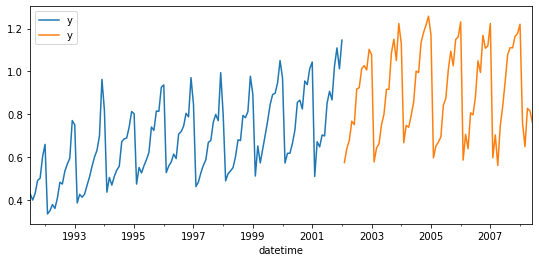

,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159
1991-10-01,0.492543


In [80]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='validation')
ax.legend()
plt.show()

display(data.head(4))

In [82]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data.loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = False,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 127
Number of observations used for backtesting: 77
    Number of folds: 8
    Number of steps per fold: 10
    Last fold only includes 7 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-02-01 00:00:00 -- 2002-11-01 00:00:00  (n=10)
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2002-12-01 00:00:00 -- 2003-09-01 00:00:00  (n=10)
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2003-10-01 00:00:00 -- 2004-07-01 00:00:00  (n=10)
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:00  (n=127)
    Validation: 2004-08-01 00:00:00 -- 2005-05-01 00:00:00  (n=10)
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2002-01-01 00:00:0

In [54]:
print(f"Backtest error: {metric}")

Backtest error: 0.00818535931502708


In [55]:
predictions_backtest.head(4)

,pred
2002-02-01,0.594506
2002-03-01,0.785886
2002-04-01,0.698925
2002-05-01,0.790560
